In [75]:
tickerStr = "AAPL"

In [76]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf

In [77]:
import yfinance as yf
ticker = yf.Ticker(tickerStr)
df = ticker.history(period='5y')['Close'].values
df = df.reshape(-1, 1)

In [78]:
# Preprocessing
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

def create_my_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

x_train, y_train = create_my_dataset(dataset_train)
x_test, y_test = create_my_dataset(dataset_test)

#reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [79]:
# Model Creation
tf.logging.set_verbosity(tf.logging.ERROR)
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=96, return_sequences=True))
model.add(LSTM(units=96))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
result = model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save(os.path.join("..","static","models",f"{tickerStr}.h5"))

Epoch 1/50
957/957 [==============================] - 3s 3ms/step - loss: 0.0253 - accuracy: 0.0021
Epoch 2/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0024 - accuracy: 0.0021
Epoch 3/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0020 - accuracy: 0.0021
Epoch 4/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0017 - accuracy: 0.0021
Epoch 5/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0016 - accuracy: 0.0021
Epoch 6/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.0021
Epoch 7/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0013 - accuracy: 0.0021
Epoch 8/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0012 - accuracy: 0.0021
Epoch 9/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.0021
Epoch 10/50
957/957 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.0021

In [81]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
lstm_23 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
lstm_24 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 97        
Total params: 185,953
Trainable params: 185,953
Non-trainable params: 0
_________________________________________________________________


range(1007, 1259)


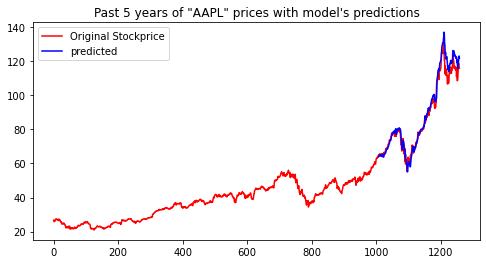

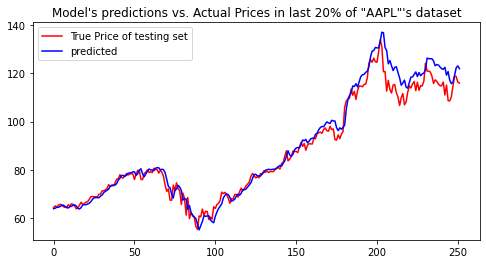

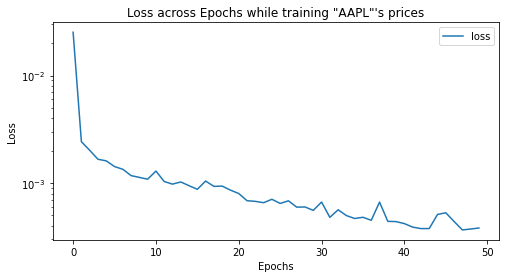

In [80]:
#visualizing overall graph
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red', label='Original Stockprice')
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions,color='blue',label='predicted')
plt.legend()
plt.title(f"Past 5 years of \"{tickerStr}\" prices with model's predictions")
print(range(len(y_train)+50,len(y_train)+50+len(predictions)))
plt.savefig(os.path.join("..","static","images","models",f"{tickerStr}_graph"))

# visualizing predictions
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Price of testing set')
plt.plot(predictions,color='blue',label='predicted')
plt.legend()
plt.title(f"Model's predictions vs. Actual Prices in last 20% of \"{tickerStr}\"'s dataset")
plt.savefig(os.path.join("..","static","images","models",f"{tickerStr}_predictions"))

# visualizing loss
def visualize_results(results):
    history = results.history
    plt.figure(figsize=(8,4))
    #plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.yscale("log")
    plt.legend(['loss'])
    plt.title(f"Loss across Epochs while training \"{tickerStr}\"'s prices")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(os.path.join("..","static","images","models",f"{tickerStr}_loss"))
    plt.show()

visualize_results(result)